<a href="https://colab.research.google.com/github/trbella/2022-05-environment_international/blob/main/notebooks/ipcc_rcp_scenarios/rcps_predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**READ ME**: 
**Author: Thiago Ribas Bella**

In this notebook I used the second best linear regression model with sarimax errors (LR-SARIMAX) to predict deaths until 2050 under RCPs scenarios.

- Second best LR-SARIMAX:
  - Data frequency: monthly
  - Model parameters: (0, 1, 1) (2, 0, 0, 12) - No intercept
  - variables: T_MIN
  - lags: 2

I chose the second best model because it uses just T_MIN as a predictor variable instead of T_MIN and pollution. The [Projeta models under RCPs scenarios](https://projeta.cptec.inpe.br/#/dashboard) don't give predictions for pollution variables. It gives only temperature and other weather variables such as humidity, radiation, rain, and wind speed.

Also, the difference between the first and the second best model is around one death (<0.1%) per month.

##**REQUIREMENTS**

In [1]:
#uploading the requirements.txt file
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving requirements.txt to requirements.txt
User uploaded file "requirements.txt" with length 750 bytes


##**INSTALLING REQUIREMENTS**

In [ ]:
!pip install -r requirements.txt

##**LIBRARIES**

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from scipy.stats import mannwhitneyu as mwu
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


##**FUNCTIONS**

In [4]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True): #Function Author: Jason Brownlee
  # dataset varaibles quantity
  n_vars = 1 if type(data) is list else data.shape[1]
  # dataframe transformation
  df = pd.DataFrame(data)
  cols, names = list(), list()

  # input sequence (t-n, ... t-1). Quantidade de lags antes do tempo t
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

  # forecast sequence (t, t+1, ... t+n). Quantidade de lags depois do tempo t
  for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
      names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    else:
      names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
  # put it all together
  agg = pd.concat(cols, axis=1)
  agg.columns = names
  # drop rows with NaN values
  if dropnan:
    agg.dropna(inplace=True)
  return agg

def mape_vectorized(true, pred): 
    mask = true != 0
    return (np.fabs(true - pred)/true)[mask].mean()*100

##**LOAD DATA**

In [5]:
df = pd.read_csv('/content/drive/Shared drives/Clima&Saúde/Dados/Dados_Saude/Obitos_SSC/data/processed/2001-2018_obitos_clima_diario.csv')
df['DATE'] = pd.to_datetime(df['DATE'],dayfirst=True)
df = df.set_index('DATE')
df.head(5)

,CO_MIN,CO_MAX,CO_MEAN,PM10_MIN,PM10_MAX,PM10_MEAN,TMIN_IAC,TMAX_IAC,TMIN_VC,TMAX_VC,...,mi_black_F,avc_white,avc_brown,avc_black,avc_white_M,avc_brown_M,avc_black_M,avc_white_F,avc_brown_F,avc_black_F
DATE,,,,,,,,,,,,,,,,,,,,,
2001-01-01,0.6,1.2,0.804348,NaN,NaN,NaN,18.2,28.2,17.8,27.9,...,0,2,0,0,0,0,0,2,0,0
2001-01-02,0.4,1.9,1.078261,NaN,NaN,NaN,17.8,30.0,16.6,29.8,...,0,1,0,0,0,0,0,1,0,0
2001-01-03,0.4,2.5,1.239130,NaN,NaN,NaN,18.0,30.4,17.3,29.6,...,0,2,0,0,2,0,0,0,0,0
2001-01-04,0.5,2.0,1.166667,23.0,65.0,44.7,18.4,30.4,17.8,30.0,...,0,2,0,0,1,0,0,1,0,0
2001-01-05,0.4,2.5,1.334783,4.0,59.0,26.5,17.8,31.4,17.5,31.1,...,0,2,0,0,2,0,0,0,0,0


In [6]:
#renaming minimum temperature variable
df = df.rename(columns={'TMIN_IAC':'T_MIN'})

#**DEATHS PER MONTH**

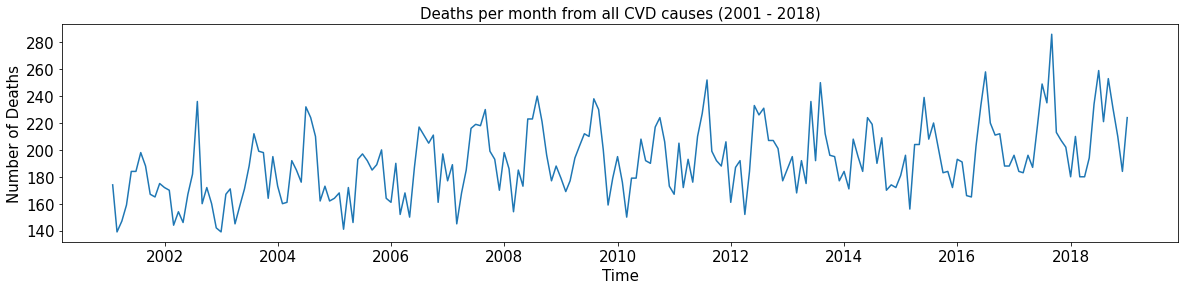

Missing values:
Endog:  0
T_MIN 0


In [7]:
# Variables
endog = df['all']
exog = df[['T_MIN']]
endog = endog.asfreq('D')
exog = exog.asfreq('D')

# Check missing values
'''print('Missing values\n')
print('Endog            ',np.sum(endog.isnull()))
print(np.sum(exog.isnull()))'''

# week data resample
endog = endog.resample('M',label='right').sum()
exog = exog.resample('M',label='right').sum()

plt.figure(figsize=(20,4))
plt.title('Deaths per month from all CVD causes (2001 - 2018)',fontsize=15)
plt.ylabel('Number of Deaths',fontsize=15)
plt.xlabel('Time',fontsize=15)
plt.plot(endog[0:])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

print('Missing values:')
print('Endog: ',np.sum(endog.isnull()))
print(f'{exog.columns.values[0]}',np.sum(exog.isnull()).sum())

##**Train/Test split 80%-20%**

In [8]:
#train/test split 80/20
n_train = int(0.82*len(exog))
endog_train = endog.iloc[:n_train].asfreq('M')
endog_test = endog.iloc[n_train:].asfreq('M')
exog_train = exog.iloc[:n_train].asfreq('M')
exog_test = exog.iloc[n_train:].asfreq('M')

##**Adding lags of the predictor variables**

In [9]:
# load dataset
train_np = exog_train[['T_MIN']].values
np.set_printoptions(suppress=True) #supress scientific notation
train_np = train_np.astype('float32') # ensure all data is float

# load dataset
test_np = exog_test[['T_MIN']].values
np.set_printoptions(suppress=True) #supress scientific notation
test_np = test_np.astype('float32') # ensure all data is float

# specify the number of lag (hours in this case, since each line equals a week)
n_hours = 2

# frame as supervised learning
reframed = series_to_supervised(train_np[:,:], n_hours, 0)
reframed_test = series_to_supervised(test_np[:,:], n_hours, 0)
reframed_all = series_to_supervised(exog[['T_MIN']], n_hours, 0)

reframed.head()

,var1(t-2),var1(t-1)
2,595.400024,556.799988
3,556.799988,588.000000
4,588.000000,533.000000
5,533.000000,425.399994
6,425.399994,396.799988


##**Model Fit** - *training set*

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  175
Model:             SARIMAX(0, 1, 1)x(2, 0, [], 12)   Log Likelihood                -747.644
Date:                             Tue, 19 Apr 2022   AIC                           1507.288
Time:                                     18:13:30   BIC                           1526.243
Sample:                                          0   HQIC                          1514.977
                                             - 175                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
var1(t-2)      0.0263      0.035      0.748      0.455      -0.043       0.095
var1(t-1)     -0.1518      

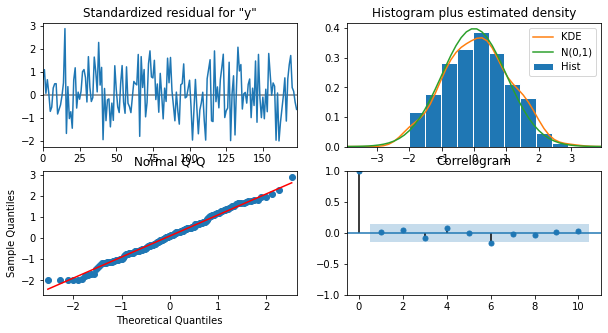

In [10]:
# Fit the model with statsmodels

mod = SARIMAX(endog_train[n_hours:].values, exog=reframed, order=(0,1,1),seasonal_order= (2,0,0,12),trend=None)
fit_res = mod.fit(maxiter=500,method='bfgs',disp=0) #disp controls verbosity
print(fit_res.summary())
print('\033[1m'+'Residuals mean ='+'\033[0m', round(fit_res.resid.mean(),5))
normal = np.random.normal(0,fit_res.resid.std(),len(fit_res.resid)) #theoretical normal distribution
mann = mwu(normal,fit_res.resid,alternative = 'two-sided') #normality test
print('\033[4m'+'\nTheoretical normal vs Residuals - hypothesis test:'+'\033[0m')
print('\033[1m'+'Mann-Whitney U p-value:'+'\033[0m', round(mann[1],5))

fit_res.plot_diagnostics(figsize=(10,5))
plt.show()

##**Statsmodels model** - *all data*

Here, we will pass all the data to the model to make the prediction. The parameters and coefficients will be the same as the model using the training set. The training process doesn't use the test data.

In [11]:
# All data but with estimated parameters of training set
mod = SARIMAX(endog[n_hours:], exog=reframed_all, order=(0,1,1),seasonal_order= (2,0,0,12),trend=None)
res = mod.filter(fit_res.params) #estimated parameters of training set
print(res.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                 all   No. Observations:                  214
Model:             SARIMAX(0, 1, 1)x(2, 0, [], 12)   Log Likelihood                -918.972
Date:                             Tue, 19 Apr 2022   AIC                           1849.944
Time:                                     18:13:32   BIC                           1870.112
Sample:                                 03-31-2001   HQIC                          1858.094
                                      - 12-31-2018                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
var1(t-2)      0.0263      0.033      0.803      0.422      -0.038       0.090
var1(t-1)     -0.1518      

##**Prediction graph**

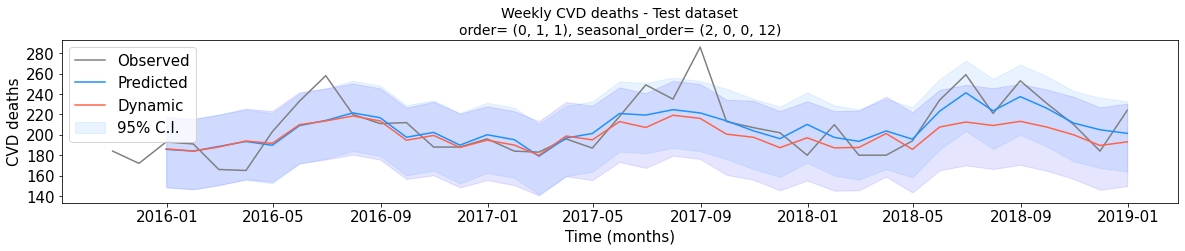

In [12]:
# predictions
predict = res.get_prediction()
predict_ci = predict.conf_int()

# Graph - Test Set
plt.figure(figsize=(20,3))
plt.title(f'''Weekly CVD deaths - Test dataset\norder= {mod.order}, seasonal_order= {mod.seasonal_order}''',fontsize=14)
plt.xlabel('Time (months)',fontsize=15)
plt.ylabel('CVD deaths',fontsize=15)
# Plot data points
plt.plot(endog_test, color='gray',label='Observed')

# Plot predictions
#one-step ahead prediction
plt.plot(predict.predicted_mean[n_train:]+fit_res.resid.mean(),color='dodgerblue', label='Predicted')
ci = predict_ci[n_train:]
plt.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='dodgerblue', alpha=0.1,label='95% C.I.')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15,loc='upper left')
#plt.show()

# Dynamic predictions
predict_dy_train = res.get_prediction(dynamic=endog.iloc[n_train:].index[0])
predict_dy_train_ci = predict_dy_train.conf_int()
plt.plot(predict_dy_train.predicted_mean[n_train:]+fit_res.resid.mean(), color='tomato',label='Dynamic')
ci = predict_dy_train_ci[n_train:]
plt.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='b', alpha=0.1)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.show()

##**Root Mean Squared Error** (*RMSE*) - Test set

In [13]:
#RMSE - Test
mse_one_test = mean_squared_error(endog[n_train+n_hours:],predict.predicted_mean[n_train:]+fit_res.resid.mean())
print('RMSE One-Step-Ahead: ',round(np.sqrt(mse_one_test),3))
#MAPE - test
mape_one_test = mape_vectorized(endog[n_train+n_hours:],predict.predicted_mean[n_train:]+fit_res.resid.mean())
print('MAPE One-Step-Ahead: ',round(mape_one_test,2),'%')

#NAIVE - MEAN VALUE
naive = pd.Series(np.repeat(endog[n_train+n_hours:].mean(),len(endog[n_train+n_hours:])))
naive.index = endog[n_train+n_hours:].index

mse_one = mean_squared_error(endog[n_train+n_hours:],naive)
print('\nNAIVE RMSE: ',round(np.sqrt(mse_one),3))
mape_one = mape_vectorized(endog[n_train+n_hours:],naive)
print('NAIVE MAPE: ',round(mape_one,2),'%')


RMSE One-Step-Ahead:  19.17
MAPE One-Step-Ahead:  6.53 %

NAIVE RMSE:  27.587
NAIVE MAPE:  10.54 %


##**PROJETA PREDICTIONS**

###**Data from Eta forecasting - coordinates from IAC (-22.871843, -47.077706)**

From 01/07/2015 to 30/12/2050

MNTP / 05 km / RCP4.5 / sudeste_D2-BR / HADGEM2_ES

MNTP - Air minimum temperature at 2 meters high

In [14]:
#LOAD DATA
eta_tmin45 = pd.read_csv('/content/drive/Shared drives/Clima&Saúde/Dados/Dados_Clima/ETA_projections/TMIN_jul_2015-dez_2050_05 km_RCP4.5_sudeste_D2-BR_HADGEM2_ES.csv',sep=';')

#Convert date to datetime format
eta_tmin45['date'] = pd.to_datetime(eta_tmin45['date'],dayfirst=True,errors='coerce')

#set date as index
eta_tmin45 = eta_tmin45.set_index('date')
eta_tmin45 = eta_tmin45.sort_index(ascending=True)

#Check NaN
#We have 63 missing values because the climate model generates inexistent days (30 and 31/february)
print('Dataset length\n')
print(len(eta_tmin45))
print('NaN count\n')
print(np.sum(eta_tmin45.isnull()))


#Also, the model doesn't generate predictions for the 31th day in the months.
#The 248 null values came from this inexistent days that were added

#reindex + add missing dates as nan values
idx = pd.date_range(eta_tmin45.index.min(),eta_tmin45.index.max())
#eta_tmin45 = eta_tmin45.reindex(idx, fill_value=eta_tmin45['TMIN_IAC'].mean())
eta_tmin45 = eta_tmin45.reindex(idx, fill_value=np.nan)
eta_tmin45.index = eta_tmin45.index.rename('date')

#Check NaN
print('Dataset length\n')
print(len(eta_tmin45))
print('NaN count\n')
print(np.sum(eta_tmin45.isnull()))
#First 3 values that are null
eta_tmin45[eta_tmin45['TMIN_IAC'].isnull()].head(3)

Dataset length

12719
NaN count

Hora         0
Latitude     0
Longitude    0
TMIN_IAC     0
dtype: int64
Dataset length

12967
NaN count

Hora         248
Latitude     248
Longitude    248
TMIN_IAC     248
dtype: int64


,Hora,Latitude,Longitude,TMIN_IAC
date,,,,
2015-07-31,NaN,NaN,NaN,NaN
2015-08-31,NaN,NaN,NaN,NaN
2015-10-31,NaN,NaN,NaN,NaN


###**Data from Eta forecasting - coordinates from IAC (-22.871843, -47.077706)**

From 01/07/2015 to 30/12/2050

MNTP / 05 km / RCP8.5 / sudeste_D2-BR / HADGEM2_ES

MNTP - Air minimum temperature at 2 meters high

In [15]:
#LOAD DATA
eta_tmin85 = pd.read_csv('/content/drive/Shared drives/Clima&Saúde/Dados/Dados_Clima/ETA_projections/TMIN_jul_2015-dez_2050_05 km_RCP8.5_sudeste_D2-BR_HADGEM2_ES.csv',sep=';')

#Convert date to datetime format
eta_tmin85['date'] = pd.to_datetime(eta_tmin85['date'],dayfirst=True,errors='coerce')

#set date as index
eta_tmin85 = eta_tmin85.set_index('date')
eta_tmin85 = eta_tmin85.sort_index(ascending=True)

#Check NaN
#We have 63 missing values because the climate model generates inexistent days (30 and 31/february)
print('Dataset length\n')
print(len(eta_tmin85))
print('NaN count\n')
print(np.sum(eta_tmin85.isnull()))


#Also, the model doesn't generate predictions for the 31th day in the months.
#The 248 null values came from this inexistent days that were added

#reindex + add missing dates as nan values
idx = pd.date_range(eta_tmin85.index.min(),eta_tmin85.index.max())
#eta_tmin85 = eta_tmin85.reindex(idx, fill_value=eta_tmin85['TMIN_IAC'].mean())
eta_tmin85 = eta_tmin85.reindex(idx, fill_value=np.nan)
eta_tmin85.index = eta_tmin85.index.rename('date')

#Check NaN
print('Dataset length\n')
print(len(eta_tmin85))
print('NaN count\n')
print(np.sum(eta_tmin85.isnull()))
#First 3 values that are null
eta_tmin85[eta_tmin85['TMIN_IAC'].isnull()].head(3)

Dataset length

12719
NaN count

Hora         0
Latitude     0
Longitude    0
TMIN_IAC     0
dtype: int64
Dataset length

12967
NaN count

Hora         248
Latitude     248
Longitude    248
TMIN_IAC     248
dtype: int64


,Hora,Latitude,Longitude,TMIN_IAC
date,,,,
2015-07-31,NaN,NaN,NaN,NaN
2015-08-31,NaN,NaN,NaN,NaN
2015-10-31,NaN,NaN,NaN,NaN


In [16]:
#forward fill - This will fill NaN values at time t with t-1 values
eta_tmin45 = eta_tmin45.fillna(method='ffill')
print('NaN count\n')
print(np.sum(eta_tmin45.isnull()))

eta_tmin45.loc['2015-07-29':'2015-07-31']

NaN count

Hora         0
Latitude     0
Longitude    0
TMIN_IAC     0
dtype: int64


,Hora,Latitude,Longitude,TMIN_IAC
date,,,,
2015-07-29,00:00:00,-22.85,-47.1,20.047241
2015-07-30,00:00:00,-22.85,-47.1,21.684021
2015-07-31,00:00:00,-22.85,-47.1,21.684021


In [17]:
#forward fill - This will fill NaN values at time t with t-1 values
eta_tmin85 = eta_tmin85.fillna(method='ffill')
print('NaN count\n')
print(np.sum(eta_tmin85.isnull()))

eta_tmin85.loc['2015-07-29':'2015-07-31']

NaN count

Hora         0
Latitude     0
Longitude    0
TMIN_IAC     0
dtype: int64


,Hora,Latitude,Longitude,TMIN_IAC
date,,,,
2015-07-29,00:00:00,-22.85,-47.1,16.060181
2015-07-30,00:00:00,-22.85,-47.1,16.930664
2015-07-31,00:00:00,-22.85,-47.1,16.930664


RCP4.5 - jul/2015-dez/2050:  19.72 °C
RCP8.5 - jul/2015-dez/2050:  20.35 °C


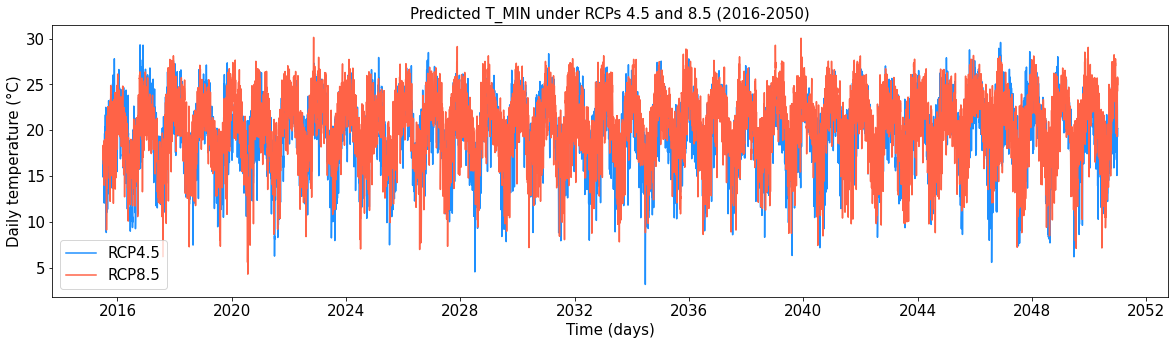

In [33]:
#mean temperatures of each time series by scenario
print('RCP4.5 - jul/2015-dez/2050: ',round(eta_tmin45['TMIN_IAC'].mean(),2),'°C')
print('RCP8.5 - jul/2015-dez/2050: ',round(eta_tmin85['TMIN_IAC'].mean(),2),'°C')

plt.figure(figsize=(20,5))
plt.plot(eta_tmin45['TMIN_IAC'],color='dodgerblue',label='RCP4.5')
plt.plot(eta_tmin85['TMIN_IAC'],color='tomato',label='RCP8.5')
plt.title('Predicted T_MIN under RCPs 4.5 and 8.5 (2016-2050)', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.xlabel('Time (days)',fontsize=15)
plt.ylabel('Daily temperature (°C)',fontsize=15)
plt.show()

In [19]:
#Resampling daily temperature predictions
eta_tmin45_M = eta_tmin45.resample('M',label='right').sum()
eta_tmin85_M = eta_tmin85.resample('M',label='right').sum()

##**Predictions for 2050**

In [20]:
# specify the number of lag (hours in this case, since each line equals a week)
n_hours = 2

# load dataset
projeta_temp45 = eta_tmin45_M[['TMIN_IAC']].values
np.set_printoptions(suppress=True) #supress scientific notation
projeta_temp45 = projeta_temp45.astype('float32') # ensure all data is float

# frame as supervised learning
reframed_projeta45 = series_to_supervised(projeta_temp45[:,:], n_hours, 0)
reframed_projeta45.head()

# load dataset
projeta_temp85 = eta_tmin85_M[['TMIN_IAC']].values
np.set_printoptions(suppress=True) #supress scientific notation
projeta_temp85 = projeta_temp85.astype('float32') # ensure all data is float

# frame as supervised learning
reframed_projeta85 = series_to_supervised(projeta_temp85[:,:], n_hours, 0)
reframed_projeta85.head()


reframed_projeta45['date'] = eta_tmin45_M[2:].index
reframed_projeta45.set_index(reframed_projeta45['date'],inplace=True)
reframed_projeta85['date'] = eta_tmin85_M[2:].index
reframed_projeta85.set_index(reframed_projeta85['date'],inplace=True)

reframed_projeta45 = reframed_projeta45.drop(columns = ['date'])
reframed_projeta85 = reframed_projeta85.drop(columns = ['date'])

In [21]:
# All data but with estimated parameters of training set
mod = SARIMAX(endog[n_hours:], exog=reframed_all, order=(0,1,1),seasonal_order= (2,0,0,12),trend=None)
res = mod.filter(fit_res.params) #estimated parameters of training set
print(res.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                 all   No. Observations:                  214
Model:             SARIMAX(0, 1, 1)x(2, 0, [], 12)   Log Likelihood                -918.972
Date:                             Tue, 19 Apr 2022   AIC                           1849.944
Time:                                     18:13:35   BIC                           1870.112
Sample:                                 03-31-2001   HQIC                          1858.094
                                      - 12-31-2018                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
var1(t-2)      0.0263      0.033      0.803      0.422      -0.038       0.090
var1(t-1)     -0.1518      

In [ ]:
# In-sample one-step-ahead predictions
predict = res.get_prediction()
predict_ci = predict.conf_int()

# Dynamic predictions
#predict_dy_45 = res.get_prediction(start=reframed_projeta85.index[0],end=reframed_projeta45.index[-1] ,exog=reframed_projeta45[-384:])
predict_dy_45 = fit_res.get_forecast(steps=423,exog = reframed_projeta45[1:])
predict_dy_ci_45 = predict_dy_45.conf_int()

# Dynamic predictions
#predict_dy_85 = res.get_prediction(start=reframed_projeta85.index[0],end=reframed_projeta85.index[-1] ,exog=reframed_projeta85[-384:])
predict_dy_85 = fit_res.get_forecast(steps=423,exog = reframed_projeta85[1:])
predict_dy_ci_85 = predict_dy_85.conf_int()

In [ ]:
#index in the dynamic predictions
rcp45_predictions = pd.DataFrame(predict_dy_45.predicted_mean)
rcp45_predictions['date'] = reframed_projeta45[1:].index
rcp45_predictions['date'] = pd.to_datetime(rcp45_predictions['date'])
rcp45_predictions = rcp45_predictions.set_index(rcp45_predictions['date'])
rcp45_predictions = rcp45_predictions.drop(columns=['date'])

rcp85_predictions = pd.DataFrame(predict_dy_85.predicted_mean)
rcp85_predictions['date'] = reframed_projeta85[1:].index
rcp85_predictions['date'] = pd.to_datetime(rcp85_predictions['date'])
rcp85_predictions = rcp85_predictions.set_index(rcp85_predictions['date'])
rcp85_predictions = rcp85_predictions.drop(columns=['date'])

#confidence intervals
ci45 = predict_dy_ci_45[:]
ci45['date'] = reframed_projeta45[1:].index
ci45['date'] = pd.to_datetime(ci45['date'])
ci45 = ci45.set_index(ci45['date'])
ci45 = ci45.drop(columns=['date'])

ci85 = predict_dy_ci_85[:]
ci85['date'] = reframed_projeta85[1:].index
ci85['date'] = pd.to_datetime(ci85['date'])
ci85 = ci85.set_index(ci85['date'])
ci85 = ci85.drop(columns=['date'])

##**Monthly CVD deaths under RCPs scenarios**

mean cvd deaths - observed: 191 2
mean cvd deaths -  RCP4.5 (2016-2050): 185 2
mean cvd deaths - RCP8.5 (2016-2050): 183 2


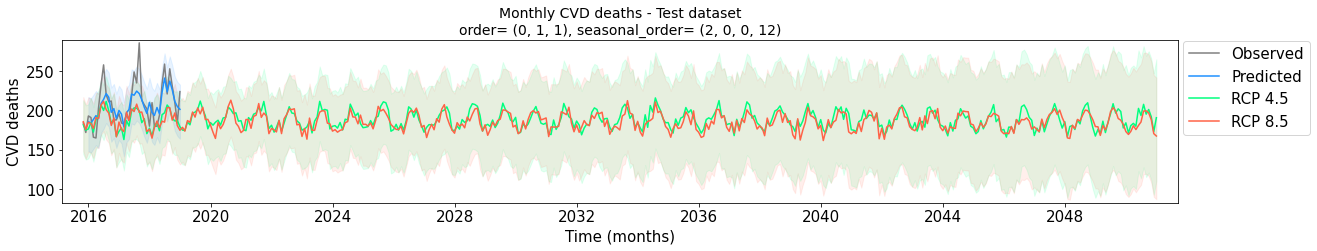

In [24]:
#mean predicted deaths (2018-2050)
print('mean cvd deaths - observed:',round(endog.mean()),2)
print('mean cvd deaths -  RCP4.5 (2016-2050):',round(predict_dy_45.predicted_mean.mean()),2)
print('mean cvd deaths - RCP8.5 (2016-2050):',round(predict_dy_85.predicted_mean.mean()),2)

# Graph - Test Set
plt.figure(figsize=(20,3))
plt.title(f'''Monthly CVD deaths - Test dataset\norder= {mod.order}, seasonal_order= {mod.seasonal_order}''',fontsize=14)
plt.xlabel('Time (months)',fontsize=15)
plt.ylabel('CVD deaths',fontsize=15)

# Plot data points
plt.plot(endog_test, color='gray',label='Observed')

#one-step - actual data
plt.plot(predict.predicted_mean[n_train:]+fit_res.resid.mean(),color='dodgerblue', label='Predicted')
ci = predict_ci[n_train:]
plt.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='dodgerblue', alpha=0.1)

# Dynamic predictions for RCP 4.5
plt.plot(rcp45_predictions['predicted_mean']+fit_res.resid.mean(), color='springgreen',label='RCP 4.5')
plt.fill_between(ci45.index, ci45.iloc[:,0], ci45.iloc[:,1], color='springgreen', alpha=0.1)

# Dynamic predictions for RCP 8.5
plt.plot(rcp85_predictions['predicted_mean']+fit_res.resid.mean(), color='tomato',label='RCP 8.5')
plt.fill_between(ci85.index, ci85.iloc[:,0], ci85.iloc[:,1], color='tomato', alpha=0.1)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15,bbox_to_anchor=(1.125,1.04))
plt.margins(0.02)
plt.show()

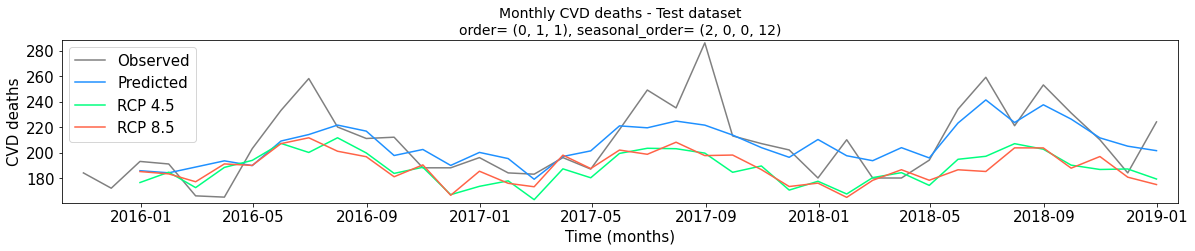

In [25]:
# Graph - Test Set
plt.figure(figsize=(20,3))
plt.title(f'''Monthly CVD deaths - Test dataset\norder= {mod.order}, seasonal_order= {mod.seasonal_order}''',fontsize=14)
plt.xlabel('Time (months)',fontsize=15)
plt.ylabel('CVD deaths',fontsize=15)

# Plot data points
plt.plot(endog_test, color='gray',label='Observed')

#one-step
plt.plot(predict.predicted_mean[n_train:]+fit_res.resid.mean(),color='dodgerblue', label='Predicted')
ci = predict_ci[n_train:]
#plt.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='dodgerblue', alpha=0.1,label='95% C.I.')


# Dynamic predictions for RCP 4.5
plt.plot(rcp45_predictions['predicted_mean'][2:39]+fit_res.resid.mean(), color='springgreen',label='RCP 4.5')
ci = ci45[2:39]
#plt.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='springgreen', alpha=0.1)

# Dynamic predictions for RCP 8.5
plt.plot(rcp85_predictions['predicted_mean'][2:39]+fit_res.resid.mean(), color='tomato',label='RCP 8.5')
ci = ci85[2:39]
#plt.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='tomato', alpha=0.1)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15,loc='best')
plt.margins(0.02)
plt.show()

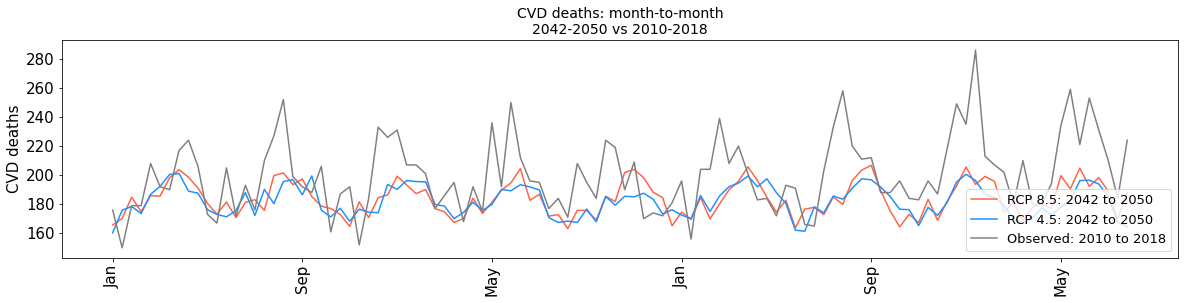

In [26]:
_, ax = plt.subplots()
df_teste0 = pd.DataFrame(dict(range_2042_to_2050=rcp45_predictions['predicted_mean']['2042':'2050'].values), index=rcp45_predictions['predicted_mean']['2042':'2050'].index.strftime('%b'))
df_teste1 = pd.DataFrame(dict(range_2042_to_2050=rcp85_predictions['predicted_mean']['2042':'2050'].values), index=rcp45_predictions['predicted_mean']['2042':'2050'].index.strftime('%b'))
df_teste2 = pd.DataFrame(dict(range_2010_to_2018=endog.loc['2010':'2018'].values), index=rcp45_predictions['predicted_mean']['2042':'2050'].index.strftime('%b'))
df_teste0.plot(ax=ax,figsize=(20,4),color='tomato')
df_teste1.plot(ax=ax,figsize=(20,4),color='dodgerblue')
df_teste2.plot(ax=ax,figsize=(20,4),color='gray')
ax.legend(["RCP 8.5: 2042 to 2050","RCP 4.5: 2042 to 2050", "Observed: 2010 to 2018"],fontsize=13,loc='lower right')
plt.xticks(fontsize=14,rotation=90)
plt.ylabel('CVD deaths',fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel('')
plt.title('CVD deaths: month-to-month\n2042-2050 vs 2010-2018',fontsize=14)
plt.yticks(fontsize=15)
plt.show()

We used a ***dynamic forecast*** for the RCP's scenarios in this prediction. In a ***dynamic forecast***, previous predictions are used to make new predictions. In other words, the number of CVD death predicted today would be used in tomorrow's prediction, and so on. Generally, we use this approach when we do not have the actual values.

##**Sum of monthly T_MIN 2016-2018**



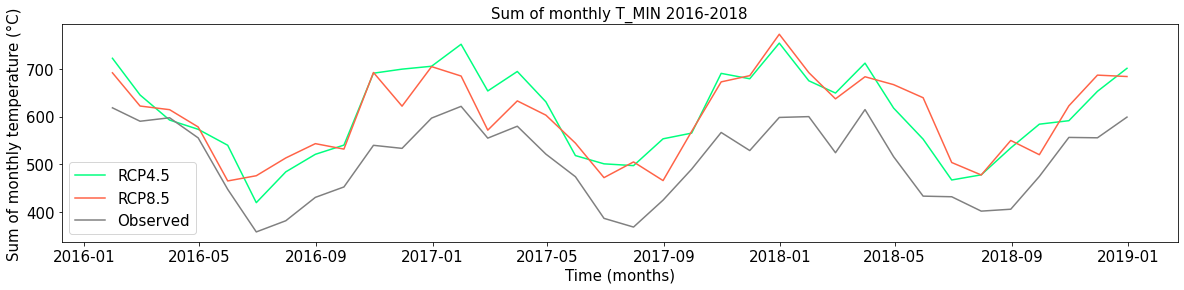

In [27]:
plt.figure(figsize=(20,4))
plt.plot(eta_tmin45_M['TMIN_IAC']['2016':'2018-12'],label='RCP4.5',color='springgreen')
plt.plot(eta_tmin85_M['TMIN_IAC']['2016':'2018-12'],label='RCP8.5',color='tomato')
plt.plot(exog_test['2016':'2018-12'],label='Observed',color='gray')
plt.title('Sum of monthly T_MIN 2016-2018', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.xlabel('Time (months)',fontsize=15)
plt.ylabel('Sum of monthly temperature (°C)',fontsize=15)
plt.show()

##**Sum of monthly T_MIN 2016-2050**



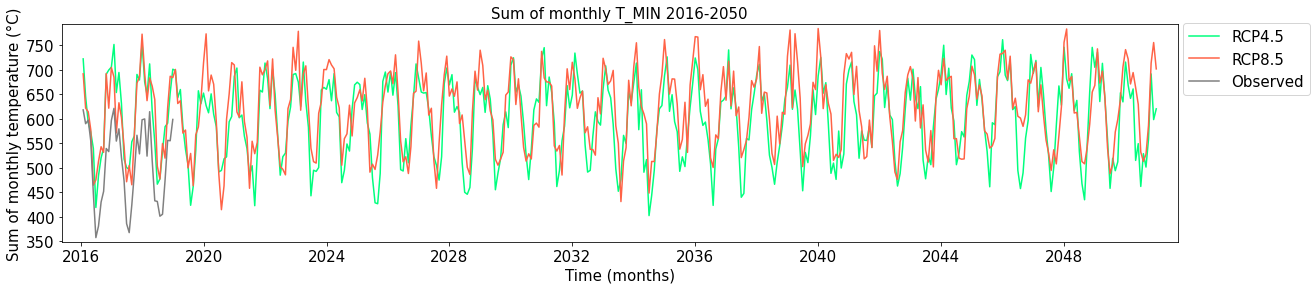

In [28]:
plt.figure(figsize=(20,4))
plt.plot(eta_tmin45_M['TMIN_IAC']['2016':],label='RCP4.5',color='springgreen')
plt.plot(eta_tmin85_M['TMIN_IAC']['2016':],label='RCP8.5',color='tomato')
plt.plot(exog_test['2016':'2018-12'],label='Observed',color='gray')
plt.title('Sum of monthly T_MIN 2016-2050', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15,bbox_to_anchor=(1.125,1.04))
plt.margins(0.02)
plt.xlabel('Time (months)',fontsize=15)
plt.ylabel('Sum of monthly temperature (°C)',fontsize=15)
plt.show()

##**Descriptive statistics - T_MIN**

- **Observed**: 2016-2018
- **RCP4.5**: 2016-2050
- **RCP8.5**: 2016-2050

In [29]:
describe = pd.DataFrame()
describe['observed'] = df['T_MIN']['2016':'2018-12'].describe()
describe['RCP4.5'] = eta_tmin45['TMIN_IAC']['2016':].describe()
describe['RCP8.5'] = eta_tmin85['TMIN_IAC']['2016':].describe()
describe[1:]

,observed,RCP4.5,RCP8.5
mean,16.715967,19.721177,20.370403
std,3.323715,3.617768,3.673351
min,5.200000,3.178253,4.302032
25%,14.400000,17.345215,18.035553
50%,17.300000,20.154266,20.830322
75%,19.400000,22.485046,23.106903
max,22.900000,29.581818,30.137177


##**Descriptive statistics - T_MIN**

- **Observed**: 2016-2018
- **RCP4.5**: 2016-2018
- **RCP8.5**: 2016-2018

In [30]:
describe2= pd.DataFrame()
describe2['observed'] = df['T_MIN']['2016':'2018-12'].describe()
describe2['RCP4.5'] = eta_tmin45['TMIN_IAC']['2016':'2018-12'].describe()
describe2['RCP8.5'] = eta_tmin85['TMIN_IAC']['2016':'2018-12'].describe()
describe2[1:]

,observed,RCP4.5,RCP8.5
mean,16.715967,19.927091,19.706586
std,3.323715,3.867282,3.628572
min,5.200000,7.472748,6.205139
25%,14.400000,17.142189,17.328415
50%,17.300000,20.448715,19.955170
75%,19.400000,23.076538,22.474319
max,22.900000,29.319489,28.123413


##**Daily T_MIN 2016-2018**

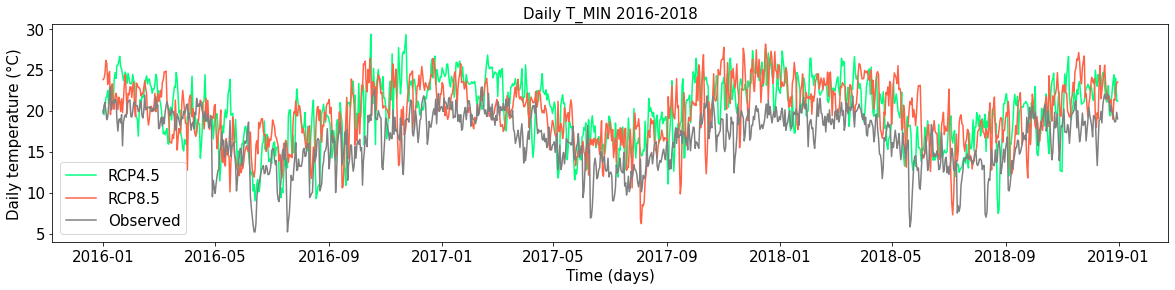

In [31]:
plt.figure(figsize=(20,4))
plt.plot(eta_tmin45['TMIN_IAC']['2016':'2018-12'],label='RCP4.5',color='springgreen')
plt.plot(eta_tmin85['TMIN_IAC']['2016':'2018-12'],label='RCP8.5',color='tomato')
plt.plot(df['T_MIN']['2016':'2018-12'],label='Observed',color='gray')
plt.title('Daily T_MIN 2016-2018', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.xlabel('Time (days)',fontsize=15)
plt.ylabel('Daily temperature (°C)',fontsize=15)
plt.show()

##**Daily T_MIN 2016-2050**

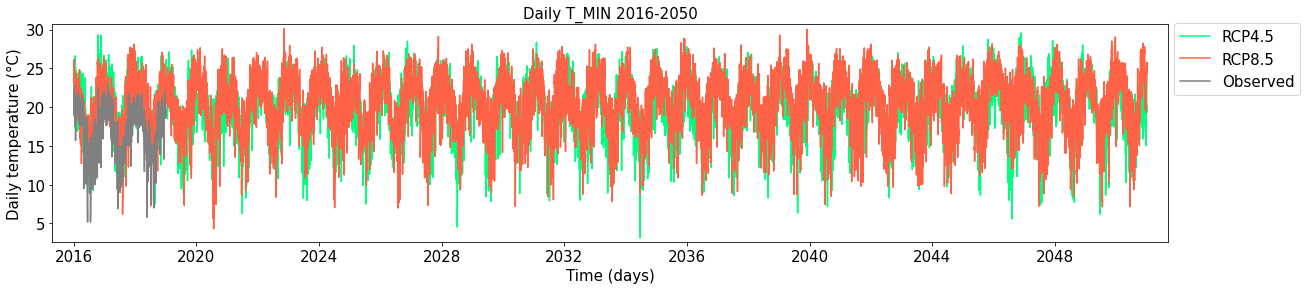

In [32]:
plt.figure(figsize=(20,4))
plt.plot(eta_tmin45['TMIN_IAC']['2016':],label='RCP4.5',color='springgreen')
plt.plot(eta_tmin85['TMIN_IAC']['2016':],label='RCP8.5',color='tomato')
plt.plot(df['T_MIN']['2016':'2018-12'],label='Observed',color='gray')
plt.title('Daily T_MIN 2016-2050', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15,bbox_to_anchor=(1.125,1.04))
plt.margins(0.02)
plt.xlabel('Time (days)',fontsize=15)
plt.ylabel('Daily temperature (°C)',fontsize=15)
plt.show()